# Green/Gamma Team Inference Exploration
<br>

![title](ros_graph_1.png)

In [154]:
import json
import pandas
import networkx
from pandas.io.json import json_normalize
from collections import defaultdict
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#The above allows for the import of local modules (ros.client) in this notebook
from ros.client import Client

In [2]:
workflow = '../../ros-t10r/translator/ros/workflows/green-cqs.ros'
libpath = [ '../../ros-t10r/translator/ros/workflows' ]
args = {
    "disease_name" : "asthma",
    "drug_name" : "Prednisone"
}
""" general. """
ros = Client (url="http://localhost:5002")
response = ros.run (workflow=workflow,
                    args = args,
                    library_path = libpath)

In [3]:
data = json.dumps(response.result) #this is a string
data_json = json.loads(data) #this is a list
icees_result_graph = data_json[0][0]['result_list'][0]['result_graph']
icees_node_list = icees_result_graph['node_list']
icees_edge_list = icees_result_graph['edge_list']
#print(icees_edge_list)

In [4]:
source_id_list = []
for x in icees_node_list:
    for key, value in x.items():
        if key == 'name':# and value == 'Prednisone':
            source_id_list.append(x['id'])
#print('source id list:', source_id_list)

In [95]:
all_icees_edges_dict = defaultdict(dict)

for x in icees_edge_list:
    icees_edge_dict = defaultdict(dict)
    for key, value in x.items():
        if key == 'source_id' and value in source_id_list:
            icees_edge_dict = defaultdict(dict)
            icees_edge_data = x['edge_attributes']
            drug_name = icees_edge_data['feature_b']['feature_name']
            source_id = value             
            if all_icees_edges_dict[drug_name]:
                all_icees_edges_dict[drug_name]['source_id'].append(source_id)
            else:
                number_patients_in_cohort = icees_edge_data['total']
                patients_with_ED_under_2_total_cohort = icees_edge_data['columns'][0]['frequency']
                patients_with_ED_over_2_total_cohort = icees_edge_data['columns'][1]['frequency']
                percentage_patients_with_ED_under_2_total_cohort = 100*patients_with_ED_under_2_total_cohort/number_patients_in_cohort
                number_patients_this_drug_EDVisits_under_2 = icees_edge_data['feature_matrix'][1][0]['frequency']
                number_patients_this_drug_EDVisits_over_2 = icees_edge_data['feature_matrix'][1][1]['frequency']
                number_patients_admin_this_drug = icees_edge_data['rows'][1]['frequency']
                number_patients_other_drugs_EDVisits_less_than_2 = icees_edge_data['feature_matrix'][0][0]['frequency']
                number_patients_other_drugs_EDVisits_over_2 = icees_edge_data['feature_matrix'][0][1]['frequency']
                number_patients_admin_other_drugs = icees_edge_data['rows'][0]['frequency']
                
                percentage_of_cohort_taking_this_drug = 100*number_patients_admin_this_drug / number_patients_in_cohort
                icees_edge_dict['Percentage of Cohort administered this Drug'] = percentage_of_cohort_taking_this_drug
                
                Prob_A_given_B = 100*number_patients_this_drug_EDVisits_under_2/number_patients_admin_this_drug
                icees_edge_dict['Percentage of Patients taking this Drug who have EDVisits < 2'] = Prob_A_given_B
                Prob_B_given_A = 100*(number_patients_this_drug_EDVisits_under_2/patients_with_ED_under_2_total_cohort)
                #icees_edge_dict['Of the patients with ED<2, percentage who are taking this Drug'] = Prob_B_given_A
                
                responsiveness_to_treatment = round(Prob_A_given_B - percentage_patients_with_ED_under_2_total_cohort, 2)
                icees_edge_dict['Responsiveness to Treatment given Administration of this Drug'] = responsiveness_to_treatment
                
                weighted_responsiveness_to_treatment = responsiveness_to_treatment*percentage_of_cohort_taking_this_drug
                icees_edge_dict['Weighted Responsiveness'] = weighted_responsiveness_to_treatment / 100
                
                #responsive_weighted_responsivness = responsiveness_to_treatment*number_patients_this_drug_EDVisits_under_2 / patients_with_ED_under_2_total_cohort
                #icees_edge_dict['Responsiveness Weighted Responsiveness'] = responsive_weighted_responsivness
                
                all_icees_edges_dict[drug_name]=dict(icees_edge_dict)
                all_icees_edges_dict[drug_name]['source_id'] = []
                all_icees_edges_dict[drug_name]['source_id'].append(source_id) 

# CQ4 Goal: Ranked list of FDA-approved medications that are effective in patients with asthma and high levels of exposure to airborne pollutants

## COHORT:45 --> size: 21492, features: AvgDailyPM2.5Exposure > 2

In [97]:
all_icees_edges_dict_df = pandas.DataFrame(all_icees_edges_dict)
efficacy_sorted_icees_edges_dict_df= all_icees_edges_dict_df.T.sort_values('Percentage of Patients taking this Drug who have EDVisits < 2', ascending=False).T
efficacy_sorted_icees_edges_dict_df.round(2)

,Mometasone,Cetirizine,Budesonide,Albuterol,Prednisone,Diphenhydramine,Salmeterol
Percentage of Cohort administered this Drug,1.56803,5.25312,4.59241,28.8759,10.483,13.3864,0.204727
Percentage of Patients taking this Drug who have EDVisits < 2,91.3947,87.2453,87.0314,82.1624,75.4993,75.113,59.0909
Responsiveness to Treatment given Administration of this Drug,8.1,3.95,3.74,-1.13,-7.8,-8.18,-24.21
Weighted Responsiveness,0.12701,0.207498,0.171756,-0.326297,-0.817672,-1.09501,-0.0495645
source_id,[PUBCHEM:441335],"[MESH:D017332, PUBCHEM:2678]","[MESH:D019819, PUBCHEM:5281004]","[MESH:D000420, PUBCHEM:2083]","[MESH:D011241, PUBCHEM:5865]","[MESH:D004155, PUBCHEM:3100]",[PUBCHEM:5152]


# Percentage of Patients taking this Drug who have EDVisits < 2 =
## (# patients administered drug AND with EDVisits < 2) / (# patients administered drug)
## ***

# Responsiveness to Treatment given Administration of this Drug = 
## (% patients administered drug AND with EDVisits< 2) - (% patients cohort with EDVisits<2)

## ***

# Weighted Responsiveness = 

## (Responsiveness * (% of patients administered this drug)) / 100

## ***

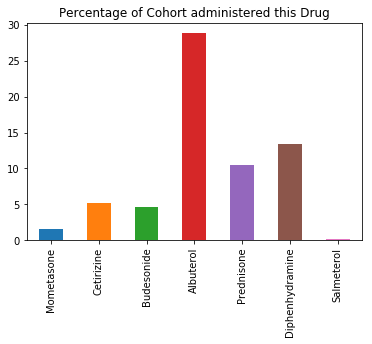

In [115]:
plot0 = efficacy_sorted_icees_edges_dict_df.iloc[0].plot(kind='bar',title = 'Percentage of Cohort administered this Drug')

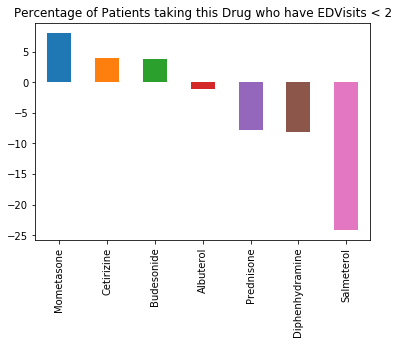

In [100]:
plot2 = efficacy_sorted_icees_edges_dict_df.iloc[2].plot(kind='bar',title = 'Percentage of Patients taking this Drug who have EDVisits < 2')

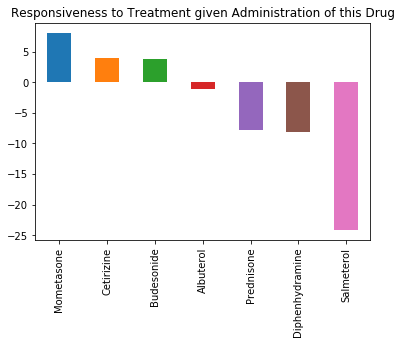

In [103]:
plot3 = efficacy_sorted_icees_edges_dict_df.iloc[2].plot(kind='bar',title = 'Responsiveness to Treatment given Administration of this Drug')

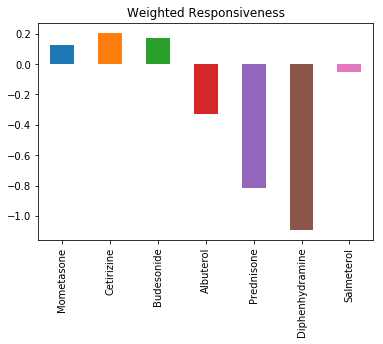

In [102]:
plot3 = efficacy_sorted_icees_edges_dict_df.iloc[3].plot(kind='bar',title = 'Weighted Responsiveness')

# CQ4 OUTPUT: 'Cetirizine', 'Budesonide', 'Mometasone' are the three most effective FDA-approved medications in patients with asthma and high levels of exposure of airborne pollutants (AvgDailyPM2.5Exposure > 2), in terms of weighted responsiveness to treatment

In [125]:
weighted_responsiveness_sorted_icees_edges_dict_df= all_icees_edges_dict_df.T.sort_values('Weighted Responsiveness', ascending=False).T
thing = list(weighted_responsiveness_sorted_icees_edges_dict_df)
thing

['Cetirizine',
 'Budesonide',
 'Mometasone',
 'Salmeterol',
 'Albuterol',
 'Prednisone',
 'Diphenhydramine']

# CQ5 Goal:  Ranked lists of the protein (gene) targets and biological pathways of FDA-approved medications that are effective in patients with asthma and high levels of exposure to airborne pollutants

# BELOW IS EXPERIMENTAL STUFF, AS OF NOV 1 2018

In [ ]:
best_drugs_list = list(weighted_responsiveness_sorted_icees_edges_dict_df[:3])
three_best_drugs = best_drugs_list[:3]
best_drug_graphs = {}

for x in three_best_drugs:
    workflow = '../../ros-t10r/translator/ros/workflows/green-cqs.ros'
    libpath = [ '../../ros-t10r/translator/ros/workflows' ]
    args = {
        "disease_name" : "asthma",
        "drug_name" : x
    }
    """ general. """
    ros = Client (url="http://localhost:5002")
    response = ros.run (workflow=workflow,
                        args = args,
                        library_path = libpath)
    
    data = json.dumps(response.result) #this is a string
    data_json = json.loads(data) #this is a list
    omni_result_graph = data_json[1][0]['result_list'][0]['result_graph']
    best_drug_graphs[x] = omni_result_graph

### The above is currently offline, pending 'ros' cache-related update

In [77]:
pred_source_list = all_icees_edges_dict['Prednisone']['source_id']
pred_source_list

['MESH:D011241', 'PUBCHEM:5865']

In [146]:
all_icees_edges_dict_df = pandas.DataFrame(all_icees_edges_dict)
efficacy_sorted_icees_edges_dict_df= all_icees_edges_dict_df.T.sort_values('Percentage of Patients taking this Drug who have EDVisits < 2', ascending=False).T
efficacy_sorted_icees_edges_dict_df.loc['new'] = ['1','2','3','4','5','6','7']
efficacy_sorted_icees_edges_dict_df['Prednisone'].loc['source_id']

['MESH:D011241', 'PUBCHEM:5865']

In [197]:
# for edge in omni_result_graph['edge_list']:
#     for key, value in edge.items():
#         print(key, value)
#         print()

In [147]:
for node in omni_result_graph['node_list']:
    for key, value in node.items():
        print(key, value)
        print()

id MESH:D052638

name Particulate Matter

equivalent_identifiers ['MESH:D052638']

type chemical_substance

omnicorp_article_count 0

equivalent_identifiers ['NCBIGENE:3576', 'UniProtKB:A0A024RDA5', 'HGNC:6025', 'UniProtKB:C9J4T6', 'UniProtKB:P10145', 'ENSEMBL:ENSG00000169429']

name CXCL8

id HGNC:6025

type gene

omnicorp_article_count 1729

id MONDO:0004979

name asthma

equivalent_identifiers ['MONDO:0004979', 'MEDDRA:10037993', 'MEDDRA:10003553', 'MEDDRA:10079895', 'UMLS:C0004099', 'MESH:D001250', 'UMLS:C0004096', 'MEDDRA:10003565', 'MEDDRA:10003557', 'DOID:2841', 'MEDDRA:10015649', 'MEDDRA:10003555', 'MEDDRA:10003561', 'MEDDRA:10006450', 'UMLS:C3714497', 'MEDDRA:10003560', 'MEDDRA:10006070', 'MESH:D001249']

type disease

omnicorp_article_count 153062

id MESH:D052638

name Particulate Matter

equivalent_identifiers ['MESH:D052638']

type chemical_substance

omnicorp_article_count 0

name CSF2

id HGNC:2434

equivalent_identifiers ['ENSEMBL:ENSG00000164400', 'NCBIGENE:1437', 'Uni

type gene

omnicorp_article_count 37726

id MONDO:0010940

equivalent_identifiers ['OMIM:600807', 'MONDO:0010940']

name inherited susceptibility to asthma

type disease

omnicorp_article_count 5



In [198]:
# for edge in icees_result_graph['edge_list']:
#     for key, value in edge.items():
#         print(key, value)
#         print()

In [199]:
# for node in icees_result_graph['node_list']:
#     for key, value in node.items():
#         print(key, value)
#         print()

# Next Knowledge Goal: Vary AvgDailyPM2.5Exposure, examine effectiveness of drugs over that variation, look for influence of genes in that variation

# Next Implementation Goal: Convert this algorithm/code to a CLI and/or GUI tool

In [213]:
test_result_graph = data_json[1][0]['result_list'][0]['result_graph']
# test_result_graph['edge_list']

In [201]:
for x in test_result_graph['edge_list']:
    for key, value in x.items():
        print(key, value)
    print()

relation CTD:increases^expression
target_id HGNC:6025
edge_source ctd.gene_to_drug
publications ['PMID:10359894|16263508|24910982']
id 11358313
predicate_id CTD:positively_affects_expression_of
source_database ctd
source_id MESH:D052638
type increases_expression_of
ctime 1538255667.1524818
relation_label increases^expression
scoring {'num_pubs': 1, 'ngd': 0.5873529995}
weight 0.7827810439
pred increases_expression_of

relation CTD:increases^secretion
target_id HGNC:6025
edge_source ctd.gene_to_drug
publications ['PMID:10359894|10919993']
id 11358315
predicate_id CTD:positively_affects_secretion_of
source_database ctd
source_id MESH:D052638
type increases_secretion_of
ctime 1538255667.152517
relation_label increases^secretion
scoring {'num_pubs': 1, 'ngd': 0.5873529995}
weight 0.7827810439
pred increases_secretion_of

relation CTD:decreases^secretion
target_id HGNC:6025
edge_source ctd.gene_to_drug
publications ['PMID:20026096']
id 11358310
predicate_id CTD:negatively_affects_secretion_

source_id MESH:D052638
type decreases_molecular_modification_of
ctime 1538262474.3994124
relation_label decreases^phosphorylation
scoring {'num_pubs': 1, 'ngd': 0.7035579024}
weight 0.703706576
pred decreases_molecular_modification_of

relation PHAROS:gene_involved
target_id HGNC:391
edge_source pharos.disease_get_gene
publications []
id 9161086
predicate_id NCIT:R176
source_database pharos
source_id MONDO:0004979
type disease_to_gene_association
ctime 1536069400.0601602
relation_label gene_involved
scoring {'num_pubs': 0, 'ngd': 1.240048688}
weight 0.335671926
pred disease_to_gene_association

type literature_co-occurrence
id 3ad98f20-b6af-427c-af92-7661d056e49c
publications ['PMID:21378028', 'PMID:25780043', 'PMID:24030221', 'PMID:15256384', 'PMID:23526225', 'PMID:19477492', 'PMID:21828034', 'PMID:21828035', 'PMID:25956071', 'PMID:15860794', 'PMID:22371396']
source_database omnicorp
source_id HGNC:391
target_id MONDO:0004979
edge_source omnicorp.term_to_term
scoring {'num_pubs': 11, 

edge_source omnicorp.term_to_term
scoring {'num_pubs': 109, 'ngd': 0.7438812118}
weight 0.6751453791
pred literature_co-occurrence

relation CTD:increases^cleavage
target_id HGNC:270
edge_source ctd.gene_to_drug
publications ['PMID:27187980']
id 11900814
predicate_id CTD:positively_affects_degradation_of
source_database ctd
source_id MESH:D052638
type increases_degradation_of
ctime 1538297586.942751
relation_label increases^cleavage
scoring {'num_pubs': 1, 'ngd': 0.6299361765}
weight 0.7544996759
pred increases_degradation_of

relation PHAROS:gene_involved
target_id HGNC:270
edge_source pharos.disease_get_gene
publications []
id 9162506
predicate_id NCIT:R176
source_database pharos
source_id MONDO:0004979
type disease_to_gene_association
ctime 1536069400.0721538
relation_label gene_involved
scoring {'num_pubs': 0, 'ngd': 1.1397093579}
weight 0.3976791312
pred disease_to_gene_association

type literature_co-occurrence
id f0c9a465-2ebe-4190-a8cd-282643991ed8
publications ['PMID:24829399'

In [212]:
# SECOND_test_result_graph = data_json
# for x in SECOND_test_result_graph:
#     print(x)
#     print()